<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/segmentation_lane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation with advence

## 데이터셋: Highway Driving Dataset
* https://sites.google.com/site/highwaydrivingdataset/
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/lane_ds.PNG?raw=true)

### 1. 데이터셋 다운로드
* https://drive.google.com/u/0/uc?id=1DsHXu0u6PnGNkqz0wJpDCVHIaRs8facP&export=download

In [61]:
! gdown https://drive.google.com/u/0/uc?id=1DsHXu0u6PnGNkqz0wJpDCVHIaRs8facP&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1DsHXu0u6PnGNkqz0wJpDCVHIaRs8facP
To: /content/HighwayDriving.tar.gz
100% 675M/675M [00:13<00:00, 49.2MB/s]


In [62]:
!tar -xf HighwayDriving.tar.gz

### 2. 이미지 경로 설정

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

paths = '/content/HighwayDriving/Train/'

# Training
Train_paths = sorted(glob(os.path.join(paths, 'TrainSeq*')))
classid_paths, image_paths, label_paths = [], [], []

for Train_path in Train_paths:
  print(Train_path)
  classid_paths += sorted(glob(os.path.join(Train_path, 'classid/*.png')))
  image_paths += sorted(glob(os.path.join(Train_path, 'image/*.png')))
  label_paths += sorted(glob(os.path.join(Train_path, 'label/*.png')))

print(len(classid_paths), len(image_paths), len(label_paths))

/content/HighwayDriving/Train/TrainSeq00
/content/HighwayDriving/Train/TrainSeq01
/content/HighwayDriving/Train/TrainSeq02
/content/HighwayDriving/Train/TrainSeq03
/content/HighwayDriving/Train/TrainSeq04
/content/HighwayDriving/Train/TrainSeq05
/content/HighwayDriving/Train/TrainSeq06
/content/HighwayDriving/Train/TrainSeq07
/content/HighwayDriving/Train/TrainSeq08
/content/HighwayDriving/Train/TrainSeq09
/content/HighwayDriving/Train/TrainSeq10
/content/HighwayDriving/Train/TrainSeq11
/content/HighwayDriving/Train/TrainSeq12
/content/HighwayDriving/Train/TrainSeq13
/content/HighwayDriving/Train/TrainSeq14
900 900 900


### 3. EDA

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/lane_class.PNG?raw=true)

* Road : 1, Lane : 2 (Car, Truck) : 3 나머지는 0으로
* 총 클래스 4개

In [64]:
def display_img(img, label, mask_cmap=None):

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.axis("off")
    plt.imshow(img)
    plt.imshow(label, alpha=0.6, cmap=mask_cmap)

    plt.subplot(1,3,3)
    plt.axis("off")
    plt.imshow(label, cmap=mask_cmap)

    plt.show()

(720, 1080, 3) (720, 1080) (720, 1080, 3)


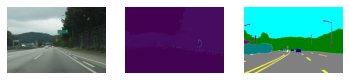

In [65]:
import matplotlib.pyplot as plt

idx = 1

img = plt.imread(image_paths[idx])
classid = plt.imread(classid_paths[idx])
label = plt.imread(label_paths[idx])

print(img.shape, classid.shape, label.shape)

img_list = [img, classid, label]

for i in range(3):
  plt.subplot(1,3, i+1)
  plt.axis("off")
  plt.imshow(img_list[i])

plt.show()

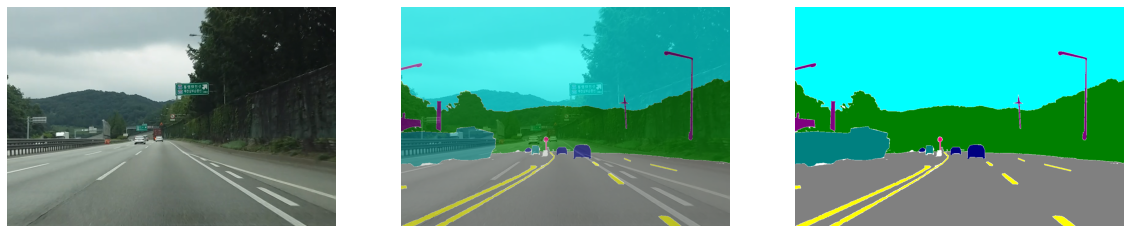

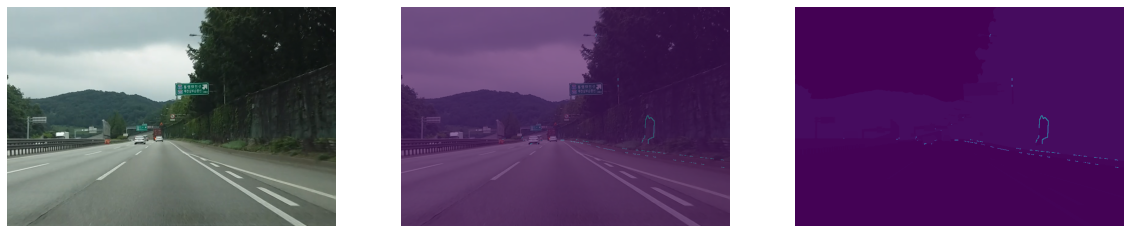

In [66]:
display_img(img, label)
display_img(img, classid)

## Data Generator with augmentation
---


In [113]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class DataGenerator():
  def __init__(self, img_size, batch_size):
    self.img_size = img_size
    self.batch_size = batch_size

  def path2arr(self, path, mask=False):
    # img 일때
    if not mask:
      # path -> img
      img = load_img(path, color_mode='rgb', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')
    
    # mask 일때
    else:
      # path -> img
      img = load_img(path, color_mode='grayscale', target_size=(self.img_size, self.img_size))
      # img -> arr
      org_arr = img_to_array(img, dtype='uint8')
      # mask id custom
      arr = np.zeros_like(org_arr)
      arr[org_arr == 1] = 1 # Road -> 1
      arr[org_arr == 2] = 2 # Lane -> 2
      arr[org_arr == 6] = 3 # Car(6) -> 3
      arr[org_arr == 7] = 3 # Truck(7) -> 3

    return arr
  
  def load_datasets(self, img_paths, mask_paths):
    img_arrs = []
    mask_arrs = []

    for img_path, mask_path in zip(img_paths, mask_paths):
      img_arr = self.path2arr(img_path)
      img_arrs.append(img_arr)

      mask_arr = self.path2arr(mask_path, mask=True)
      mask_arrs.append(mask_arr)
    
    return np.array(img_arrs), np.array(mask_arrs)
  
  def preprocess(self, img_arr, mask_arr):
    img_arr = (img_arr / 127.5) -1

    return img_arr, mask_arr
  
  def tf_preprocess(self, img_arr, mask_arr):
    img_arr = (tf.cast(img_arr, tf.float32) / 127.5)
    mask_arr = tf.cast(mask_arr, tf.float32) # int -> float

    return img_arr, mask_arr
  
  def augment(slef, img, mask):
    # 밝기랜덤조절
    img = tf.image.random_brightness(img, max_delta=0.2)

    img = tf.image.random_contrast(img, 0.5, 2.0)
    img = tf.image.random_saturation(img, 0.75, 1.25)

    img = tf.clip_by_value(img, -1, 1)

    ds = tf.concat((img, mask), axis=2)
    # 좌우랜덤반전 / 상하랜덤반전
    ds = tf.image.random_flip_left_right(ds)
    #ds = tf.image.random_flip_up_down(ds)
    
    # 이미지 사이즈 증가(padding)
    #pd_size = 50
    #img = tf.image.resize_with_crop_or_pad(img, self.img_size + pad_size, self.img_size + pad_size)
    #mask = tf.mask.resize_with_crop_or_pad(mask, self.img_size + pad_size, self.img_size + pad_size)

    # 랜덤크롭
    #ds = tf.cncat((img, mask), axis=2)
    #ds = tf.image.random_crop(ds, size=[self.img_size, self.img_size, 4])
    img, mask = ds[:,:,:3], ds[:,:,-1]
    #img = (256, 256, 3)
    #mask = (256, 256) -> (256, 256,1)
    mask = tf.expand_dims(mask, axis=2)

    return img, mask

  def generate(self, img_paths, mask_paths, aug=False):
    # 기존 Numpy 이용한 데이터셋 처리
    img_arrs, mask_arrs = self.load_datasets(img_paths, mask_paths)

    # tensorflow dataset 라이브러리 사용 여기서부터는 Numpy가 아니라 Tensor 이용
    dataset = tf.data.Dataset.from_tensor_slices((img_arrs, mask_arrs))
    # shuffle
    dataset = dataset.shuffle(1)
    dataset = dataset.map(self.tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE) # 전처리, num_parallel_calls=tf.data.AUTOTUNE -> 병렬처리
    
    if aug:
      dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(self.batch_size, drop_remainder=True) # batch 사이즈 지정

    print(dataset)

    return dataset

In [114]:
IMG_SIZE = 256
BATH_SIZE = 16
dg = DataGenerator(IMG_SIZE, BATH_SIZE)

### 함수

In [115]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

def hist_val(img_arr, mask_arr):
  plt.figure(figsize=(10,4))

  plt.subplot(1,2,1)
  img_shape = img_arr.shape[0] * img_arr.shape[1] * img_arr.shape[2]
  plt.hist(np.reshape(img_arr, img_shape)) # 1차원인풋

  plt.subplot(1,2,2)
  mask_shape = mask_arr.shape[0] * mask_arr.shape[1] * mask_arr.shape[2]
  plt.hist(np.reshape(mask_arr, mask_shape)) # 1차원인풋
  print('* # of mask categories :', set(np.reshape(mask_arr, mask_shape))) # set 중복 제거, mask의 카테고리 확인

  plt.show()

def display_img(img_arr, mask_arr, mask_cmap=None):
  plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img_arr)

  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(img_arr)
  plt.imshow(mask_arr[:,:,0], alpha=0.6, cmap=mask_cmap) # mask_arr (가로, 세로, 1) -> (가로, 세로)

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask_arr[:,:,0], cmap=mask_cmap) # mask_arr (가로, 세로, 1) -> (가로, 세로)
  
  plt.show()

### 1. array 변환

(256, 256, 3) (256, 256, 1)


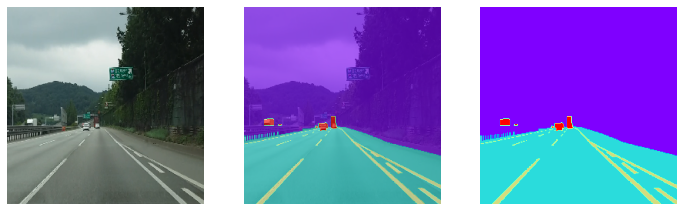

* # of mask categories : {0, 1, 2, 3}


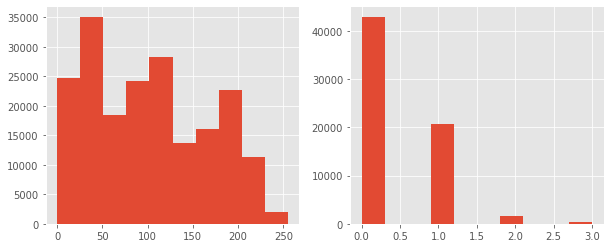

In [116]:
idx = 12

img_arr = dg.path2arr(image_paths[idx])
classid_arr = dg.path2arr(classid_paths[idx], mask=True)

print(img_arr.shape, classid_arr.shape)

display_img(img_arr, classid_arr, mask_cmap='rainbow')
hist_val(img_arr, classid_arr)

### 2. 전처리

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1)


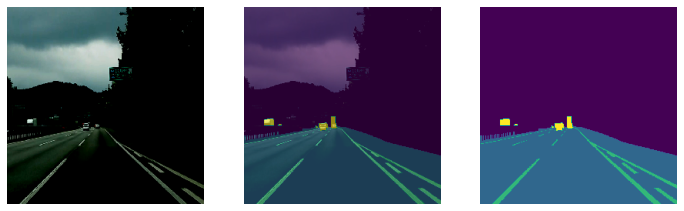

* # of mask categories : {0, 1, 2, 3}


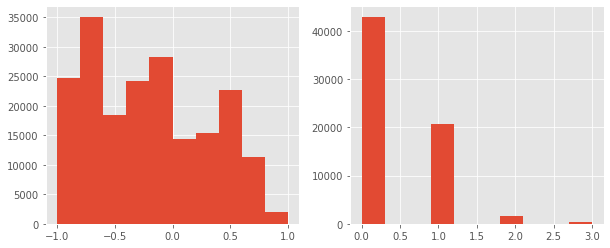

In [117]:
img_pre, mask_pre = dg.preprocess(img_arr, classid_arr)
print(img_pre.shape, mask_pre.shape)

display_img(img_pre, mask_pre)
hist_val(img_pre, mask_pre)

### 3. augmentation

* 상하 flip 제외
* 좌우 flip 사용
* 랜덤 밝기 사용
* 랜덤 크롭 제외

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1)


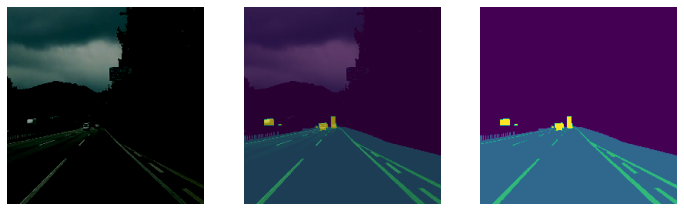

* # of mask categories : {0.0, 1.0, 2.0, 3.0}


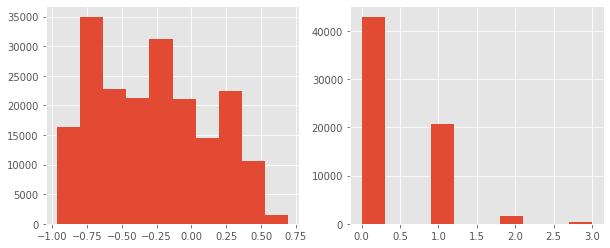

In [120]:
img_aug, mask_aug = dg.augment(img_pre, mask_pre)
print(img_aug.shape, mask_aug.shape)

display_img(img_aug, mask_aug)
hist_val(img_aug, mask_aug)

### 데이터셋 정의

In [121]:
train_ds = dg.generate(image_paths[:800], classid_paths[:800], aug=True)
valid_ds = dg.generate(image_paths[800:], classid_paths[800:])

print("* Train_ds :", train_ds)
print("* Valid_ds :", valid_ds)

<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
* Train_ds : <BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>
* Valid_ds : <BatchDataset shapes: ((16, 256, 256, 3), (16, 256, 256, 1)), types: (tf.float32, tf.float32)>


## 모델: 전이학습
---

### 1. 모델 생성

In [122]:
from tensorflow.keras import layers, models, Input, utils

base_model = models.load_model("unet_pet_aug.h5")
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [123]:
from tensorflow.keras import models, layers

NUM_CLASSES = 4
Kernel_SIZE = 3

input = base_model.input # (256,256,4)
output = base_model.layers[-2].output
output = layers.Conv2D(NUM_CLASSES, Kernel_SIZE, activation='softmax', padding='same', name='new_layer')(output)

model = models.Model(inputs=input, outputs=output)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

### 2. 모델 컴파일

In [124]:
from tensorflow.keras import losses, optimizers

loss = losses.SparseCategoricalCrossentropy() 
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

### 3. 모델 학습

In [127]:
from tensorflow.keras import callbacks

ckp = callbacks.ModelCheckpoint('new_unet.h5',
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True)

lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=10)

history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs=50,
                    callbacks=[ckp, lr]) # 학습 효과적으로

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9673

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


50/50 [==============================] - 25s 509ms/step - loss: 0.0964 - accuracy: 0.9673 - val_loss: 0.1142 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 25s 501ms/step - loss: 0.0836 - accuracy: 0.9704 - val_loss: 0.1119 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 25s 502ms/step - loss: 0.0803 - accuracy: 0.9712 - val_loss: 0.1250 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 25s 499ms/step - loss: 0.0794 - accuracy: 0.9711 - val_loss: 0.1507 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 25s 503ms/step - loss: 0.0771 - accuracy: 0.9726 - val_loss: 0.1415 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 25s 495ms/step - loss: 0.0756 - accuracy: 0.9722 - val_loss: 0.1338 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 25s 492ms/step - loss: 

### 모델 시각화

In [129]:
def plot_leraning_curve(H):
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N),  H.history["loss"], label="train_loss", marker='o',)
    plt.plot(np.arange(0, N),  H.history["val_loss"], label="val_loss", marker='o')
    plt.plot(np.arange(0, N),  H.history["accuracy"], label="train_acc", marker='o')
    plt.plot(np.arange(0, N),  H.history["val_accuracy"], label="val_acc", marker='o')
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("lerning_curve")
    plt.show()

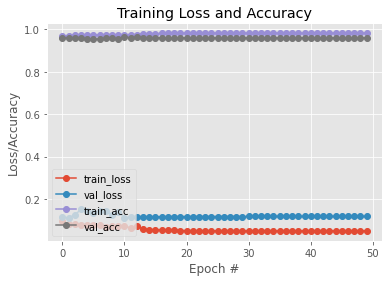

In [130]:
plot_leraning_curve((history))

### 4. 모델 평가

In [131]:
model.evaluate(valid_ds)

6/6 [==============================] - 1s 157ms/step - loss: 0.1178 - accuracy: 0.9607


[0.11781805008649826, 0.9607006907463074]

### 5. 추론

(256, 256, 3)
(256, 256)


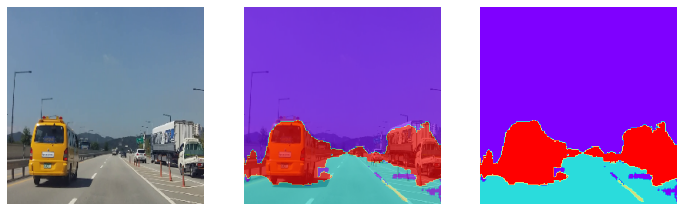

In [142]:
path = image_paths[300]
org_img = dg.path2arr(path)
test_img, _ = dg.preprocess(org_img, org_img)
print(test_img.shape)

pred = model.predict(tf.expand_dims(test_img,0))[0]
pred = np.argmax(pred, axis=2)
print(pred.shape)

display_img(org_img, np.expand_dims(pred, 2), mask_cmap='rainbow')